# Battery RUL - Modeling

---

**Mục tiêu:** Dự đoán thời gian sử dụng còn lại (RUL) của pin bằng các phương pháp học máy truyền thống, deep learning và XGBoost.

**Quy trình:**
1. Import thư viện
2. Load dữ liệu đã tiền xử lý
3. Tách dữ liệu train/test và chuẩn hóa
4. Xây dựng và huấn luyện mô hình Machine Learning
5. Xây dựng mô hình Deep Learning (LSTM, GRU, CNN)
6. Huấn luyện mô hình XGBoost tối ưu
7. Đánh giá các mô hình
8. Trực quan hóa kết quả dự đoán
9. Dự đoán thử và đánh giá chi tiết

---

## 1. Import thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

print("Thư viện đã import thành công!")

Thư viện đã import thành công!


## 2. Load dữ liệu đã tiền xử lý và Feature engineering


In [2]:
# Load dữ liệu đã tiền xử lý
file_path = r"data/processed/Battery_RUL_processed.csv"
df = pd.read_csv(file_path)
df = df.sort_values('Cycle_Index')
print("Kích thước dữ liệu:", df.shape)
print("Các cột dữ liệu:", list(df.columns))
df.describe()

Kích thước dữ liệu: (15064, 9)
Các cột dữ liệu: ['Cycle_Index', 'Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)', 'RUL']


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,2431.494567,522.232835,3.908176,3.577904,3215.651277,4146.187166,8641.906719,554.194172
std,322.378480,11948.500108,1436.811036,0.091003,0.123695,3675.177157,4755.914947,4476.833081,322.434514
min,1.000000,34.380000,38.709677,3.043000,3.022000,255.241143,8.000000,8.380000,0.000000
25%,271.000000,1168.717500,320.000000,3.846000,3.488000,1834.027286,2564.310000,7837.535000,277.000000
50%,560.000000,1555.380000,438.857143,3.906000,3.574000,2924.359000,3788.380000,8313.235000,551.000000
75%,833.000000,1906.675000,598.400000,3.972000,3.663000,4076.344000,5012.320000,8756.360000,839.000000
max,1134.000000,197940.480000,86584.925500,4.363000,4.379000,62910.013000,78270.020000,78660.000000,1133.000000


In [ ]:
## Đặc trưng vật lý

# 1. Efficiency Ratio (Tỷ lệ hiệu suất):
# Tỷ lệ giữa thời gian xả và thời gian sạc. Pin chai thường sạc lâu nhưng xả nhanh.
df['Efficiency_Ratio'] = df['Discharge Time (s)'] / df['Charging time (s)']

# 2. Voltage Drop Rate (Tốc độ sụt áp trung bình):
# (Điện áp cao nhất khi xả - Điện áp thấp nhất khi sạc) / Thời gian xả
# Pin bị chai sẽ sụt áp nhanh hơn.
voltage_range = df['Max. Voltage Dischar. (V)'] - df['Min. Voltage Charg. (V)']
df['Voltage_Drop_Rate'] = voltage_range / df['Discharge Time (s)']

## Đặc trưng thời gian

# 3. Discharge Drop Rate (Tốc độ suy giảm dung lượng):
# So sánh thời gian xả chu kỳ này với chu kỳ trước đó.
# Hàm .diff() = Giá trị dòng hiện tại - Giá trị dòng trước.
df['Discharge_Drop_Rate'] = df['Discharge Time (s)'].diff()

# 4. Rolling Mean (Xu hướng trung bình - Trend):
# Lấy trung bình 10 chu kỳ gần nhất.
# Tác dụng: Làm mượt nhiễu cục bộ, giúp mô hình thấy rõ xu hướng giảm của pin.
df['Discharge_Rolling_Mean_10'] = df['Discharge Time (s)'].rolling(window=10).mean()

# 5. Rolling Std (Độ ổn định):
# Độ lệch chuẩn của 10 chu kỳ gần nhất.
# Tác dụng: Nếu chỉ số này cao, nghĩa là pin đang hoạt động chập chờn (lúc mạnh lúc yếu) -> Sắp hỏng.
df['Discharge_Rolling_Std_10'] = df['Discharge Time (s)'].rolling(window=10).std()

# 6. Lag Feature (Giá trị trễ):
# Lấy giá trị thời gian xả của đúng chu kỳ trước đó (Cycle n-1).
# Tác dụng: Giúp mô hình dùng quá khứ để dự đoán tương lai (tính chất Markov).
df['Prev_Cycle_Discharge'] = df['Discharge Time (s)'].shift(1)

# Xử lý giá trị NaN sinh ra do tính toán đặc trưng
df = df.bfill()

In [4]:
print("\nKích thước sau Feature Engineering:", df.shape)

# Xem thống kê các cột mới để đảm bảo không có giá trị vô cực (inf)
print("\nThống kê dữ liệu mới:")
df.describe()


Kích thước sau Feature Engineering: (15064, 15)

Thống kê dữ liệu mới:


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL,Efficiency_Ratio,Voltage_Drop_Rate,Discharge_Drop_Rate,Discharge_Rolling_Mean_10,Discharge_Rolling_Std_10,Prev_Cycle_Discharge
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,2431.494567,522.232835,3.908176,3.577904,3215.651277,4146.187166,8641.906719,554.194172,0.202904,0.000193,-0.116373,2432.010385,915.677481,2431.609658
std,322.378480,11948.500108,1436.811036,0.091003,0.123695,3675.177157,4755.914947,4476.833081,322.434514,0.249596,0.000199,8022.938772,9315.986591,7833.237509,11948.493335
min,1.000000,34.380000,38.709677,3.043000,3.022000,255.241143,8.000000,8.380000,0.000000,0.024123,-0.014863,-195575.320000,589.187000,3.794736,34.380000
25%,271.000000,1168.717500,320.000000,3.846000,3.488000,1834.027286,2564.310000,7837.535000,277.000000,0.150194,0.000151,-45.620000,1170.215500,25.879104,1168.761250
50%,560.000000,1555.380000,438.857143,3.906000,3.574000,2924.359000,3788.380000,8313.235000,551.000000,0.185842,0.000210,-0.630000,1551.093000,58.732563,1555.405000
75%,833.000000,1906.675000,598.400000,3.972000,3.663000,4076.344000,5012.320000,8756.360000,839.000000,0.218967,0.000256,45.500000,1909.779500,76.922413,1906.720000
max,1134.000000,197940.480000,86584.925500,4.363000,4.379000,62910.013000,78270.020000,78660.000000,1133.000000,18.717195,0.003616,195701.510000,191661.264733,102730.502760,197940.480000


In [5]:
# Kiểm tra các cột có giá trị âm
neg_cols = [col for col in df.columns if (df[col] < 0).any()]
print("Các cột có chứa số âm:", neg_cols)

Các cột có chứa số âm: ['Voltage_Drop_Rate', 'Discharge_Drop_Rate']


In [6]:
error_mask = df['Voltage_Drop_Rate'] < 0
print(f"Phát hiện {error_mask.sum()} dòng dữ liệu lỗi điện áp (Voltage Drop Rate < 0).")

# Loại bỏ các dòng dữ liệu lỗi
df = df[~error_mask].copy()
neg_cols_final = [col for col in df.columns if (df[col] < 0).any()]
print("Các cột còn số âm:", neg_cols_final)

Phát hiện 415 dòng dữ liệu lỗi điện áp (Voltage Drop Rate < 0).
Các cột còn số âm: ['Discharge_Drop_Rate']


## 3. Tách dữ liệu train/test và chuẩn hóa

Chia dữ liệu thành tập huấn luyện (train) và kiểm tra (test) theo tỷ lệ 80/20. Chuẩn hóa bằng StandardScaler

In [7]:
# Tách dữ liệu
X = df.drop(columns=['RUL'])
y = df['RUL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (11719, 14), Test: (2930, 14)


## 4. Huấn luyện mô hình Machine Learning

In [8]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Đánh giá Linear Regression
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression:")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")
print(f"R2: {r2_lr:.4f}")

Linear Regression:
RMSE: 7.0582
MAE: 4.4195
R2: 0.9995


In [9]:
# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Đánh giá Random Forest
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"R2: {r2_rf:.4f}")

Random Forest:
RMSE: 4.4258
MAE: 2.5785
R2: 0.9998


## 5. Phát triển mô hình nâng cao (LSTM, GRU, CNN)

Áp dụng các mô hình deep learning cho dữ liệu chuỗi thời gian để dự đoán RUL.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Chuẩn bị dữ liệu cho mô hình chuỗi thời gian
def create_sequences(X, y, seq_len=50):
    X = np.array(X)
    y = np.array(y)

    Xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1])
    return np.array(Xs), np.array(ys)


In [11]:
sequence_length = 50

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)
print(f"Train seq shape: {X_train_seq.shape}, Test seq shape: {X_test_seq.shape}")

Train seq shape: (11670, 50, 14), Test seq shape: (2881, 50, 14)


In [12]:
# Hàm đánh giá model
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    # Nếu dự đoán ra 2D thì flatten
    if len(y_pred.shape) > 1:
        y_pred = y_pred.flatten()
        
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R2  : {r2:.4f}")
    return rmse, mae, r2

In [13]:
# LSTM model
lstm_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
print('Huấn luyện LSTM...')
lstm_model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

rmse_lstm, mae_lstm, r2_lstm = evaluate_model(lstm_model, X_test_seq, y_test_seq, name="LSTM")

Huấn luyện LSTM...
Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 385603.1875 - mae: 531.0103 - val_loss: 288980.5938 - val_mae: 446.2755
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 252253.3438 - mae: 411.8808 - val_loss: 150506.6250 - val_mae: 322.2596
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 133167.2812 - mae: 305.8168 - val_loss: 107106.9688 - val_mae: 282.0593
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 106608.9609 - mae: 281.9856 - val_loss: 103830.9297 - val_mae: 278.5976
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 104369.8672 - mae: 278.3146 - val_loss: 103816.8281 - val_mae: 278.5770
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 105602.1953 - mae: 280.9443 - val_loss: 103795.1875 - val_mae: 278.5440
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 104618.6172 - mae: 279.5442 - val_loss: 103823.4688 - val_mae: 278.5869
Epoch 8/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/s

In [14]:
# GRU model
gru_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
print('Huấn luyện GRU...')
gru_model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
gru_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

rmse_gru, mae_gru, r2_gru = evaluate_model(gru_model, X_test_seq, y_test_seq, name="GRU")

Huấn luyện GRU...
Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 386463.1562 - mae: 532.9796 - val_loss: 256654.5000 - val_mae: 417.5420
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 211046.3125 - mae: 376.0804 - val_loss: 121859.4375 - val_mae: 296.3525
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 111936.3984 - mae: 284.8914 - val_loss: 104215.7266 - val_mae: 279.0539
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 104293.5312 - mae: 278.3243 - val_loss: 103803.7812 - val_mae: 278.5575
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 107785.8828 - mae: 285.2434 - val_loss: 103889.0859 - val_mae: 278.6745
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 100133.9531 - mae: 269.7486 - val_loss: 22467.3828 - val_mae: 97.5358
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 16830.7285 - mae: 89.7854 - val_loss: 4576.0234 - val_mae: 38.9928
Epoch 8/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - lo

In [15]:
# CNN model
cnn_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1)
])
print('Huấn luyện CNN...')
cnn_model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
cnn_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

rmse_cnn, mae_cnn, r2_cnn = evaluate_model(cnn_model, X_test_seq, y_test_seq, name="CNN")

Huấn luyện CNN...
Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 233249.5781 - mae: 395.6665 - val_loss: 105912.2188 - val_mae: 280.1944
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 105907.1953 - mae: 280.4508 - val_loss: 104059.2109 - val_mae: 278.3478
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 102261.7422 - mae: 275.2662 - val_loss: 100643.6328 - val_mae: 273.9231
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 97519.6562 - mae: 269.1052 - val_loss: 84365.6484 - val_mae: 249.8157
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 76047.1328 - mae: 234.5058 - val_loss: 53547.6289 - val_mae: 190.4350
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 46059.8750 - mae: 174.8552 - val_loss: 38999.7344 - val_mae: 156.4977
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32563.2695 - mae: 144.3538 - val_loss: 30628.8301 - val_mae: 140.6250
Epoch 8/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26281.

## 6. Huấn luyện mô hình XGBoost tối ưu

Huấn luyện mô hình XGBoost với các tham số đã được tối ưu hóa bằng thuật toán tìm kiếm siêu tham số.

Nguồn: https://www.kaggle.com/code/exceededdose/best-rul-prediction-model

In [16]:
from xgboost import XGBRegressor

best_params = {
    'n_estimators': 236,
    'max_depth': 10,
    'learning_rate': 0.03303851203638283,
    'subsample': 0.6594050174570553,
    'colsample_bytree': 0.9712398646893982,
    'gamma': 2.6569769714190774,
    'reg_alpha': 1.2599527471696812,
    'reg_lambda': 3.351172640816224
}

best_model = XGBRegressor(**best_params, random_state=42, objective='reg:squarederror')
best_model.fit(X_train, y_train)

rmse_xgb, mae_xgb, r2_xgb = evaluate_model(best_model, X_test, y_test, name="XGBoost")

XGBoost:
  RMSE: 3.3522
  MAE : 2.1074
  R2  : 0.9999


## 7. Đánh giá các mô hình

So sánh các mô hình dựa trên các chỉ số RMSE, MAE, R2 để chọn ra mô hình tốt nhất.

In [17]:
results ={}
results['Linear Regression'] = (rmse_lr, mae_lr, r2_lr)
results['Random Forest'] = (rmse_rf, mae_rf, r2_rf)
results['LSTM'] = (rmse_lstm, mae_lstm, r2_lstm)
results['GRU'] = (rmse_gru, mae_gru, r2_gru)
results['CNN'] = (rmse_cnn, mae_cnn, r2_cnn)
results['XGBoost'] = (rmse_xgb, mae_xgb, r2_xgb)
results_df = pd.DataFrame(results, index=['RMSE', 'MAE', 'R2']).T
print(results_df)

                        RMSE        MAE        R2
Linear Regression   7.058184   4.419537  0.999510
Random Forest       4.425758   2.578514  0.999807
LSTM               20.006677  14.244881  0.996063
GRU                13.160570   8.889558  0.998296
CNN                73.282199  55.383066  0.947174
XGBoost             3.352168   2.107352  0.999889


## 8. Trực quan hóa kết quả dự đoán

Biểu đồ so sánh giá trị thực tế và dự đoán, phân bố lỗi và diễn biến RUL theo index giúp đánh giá trực quan hiệu quả mô hình.

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


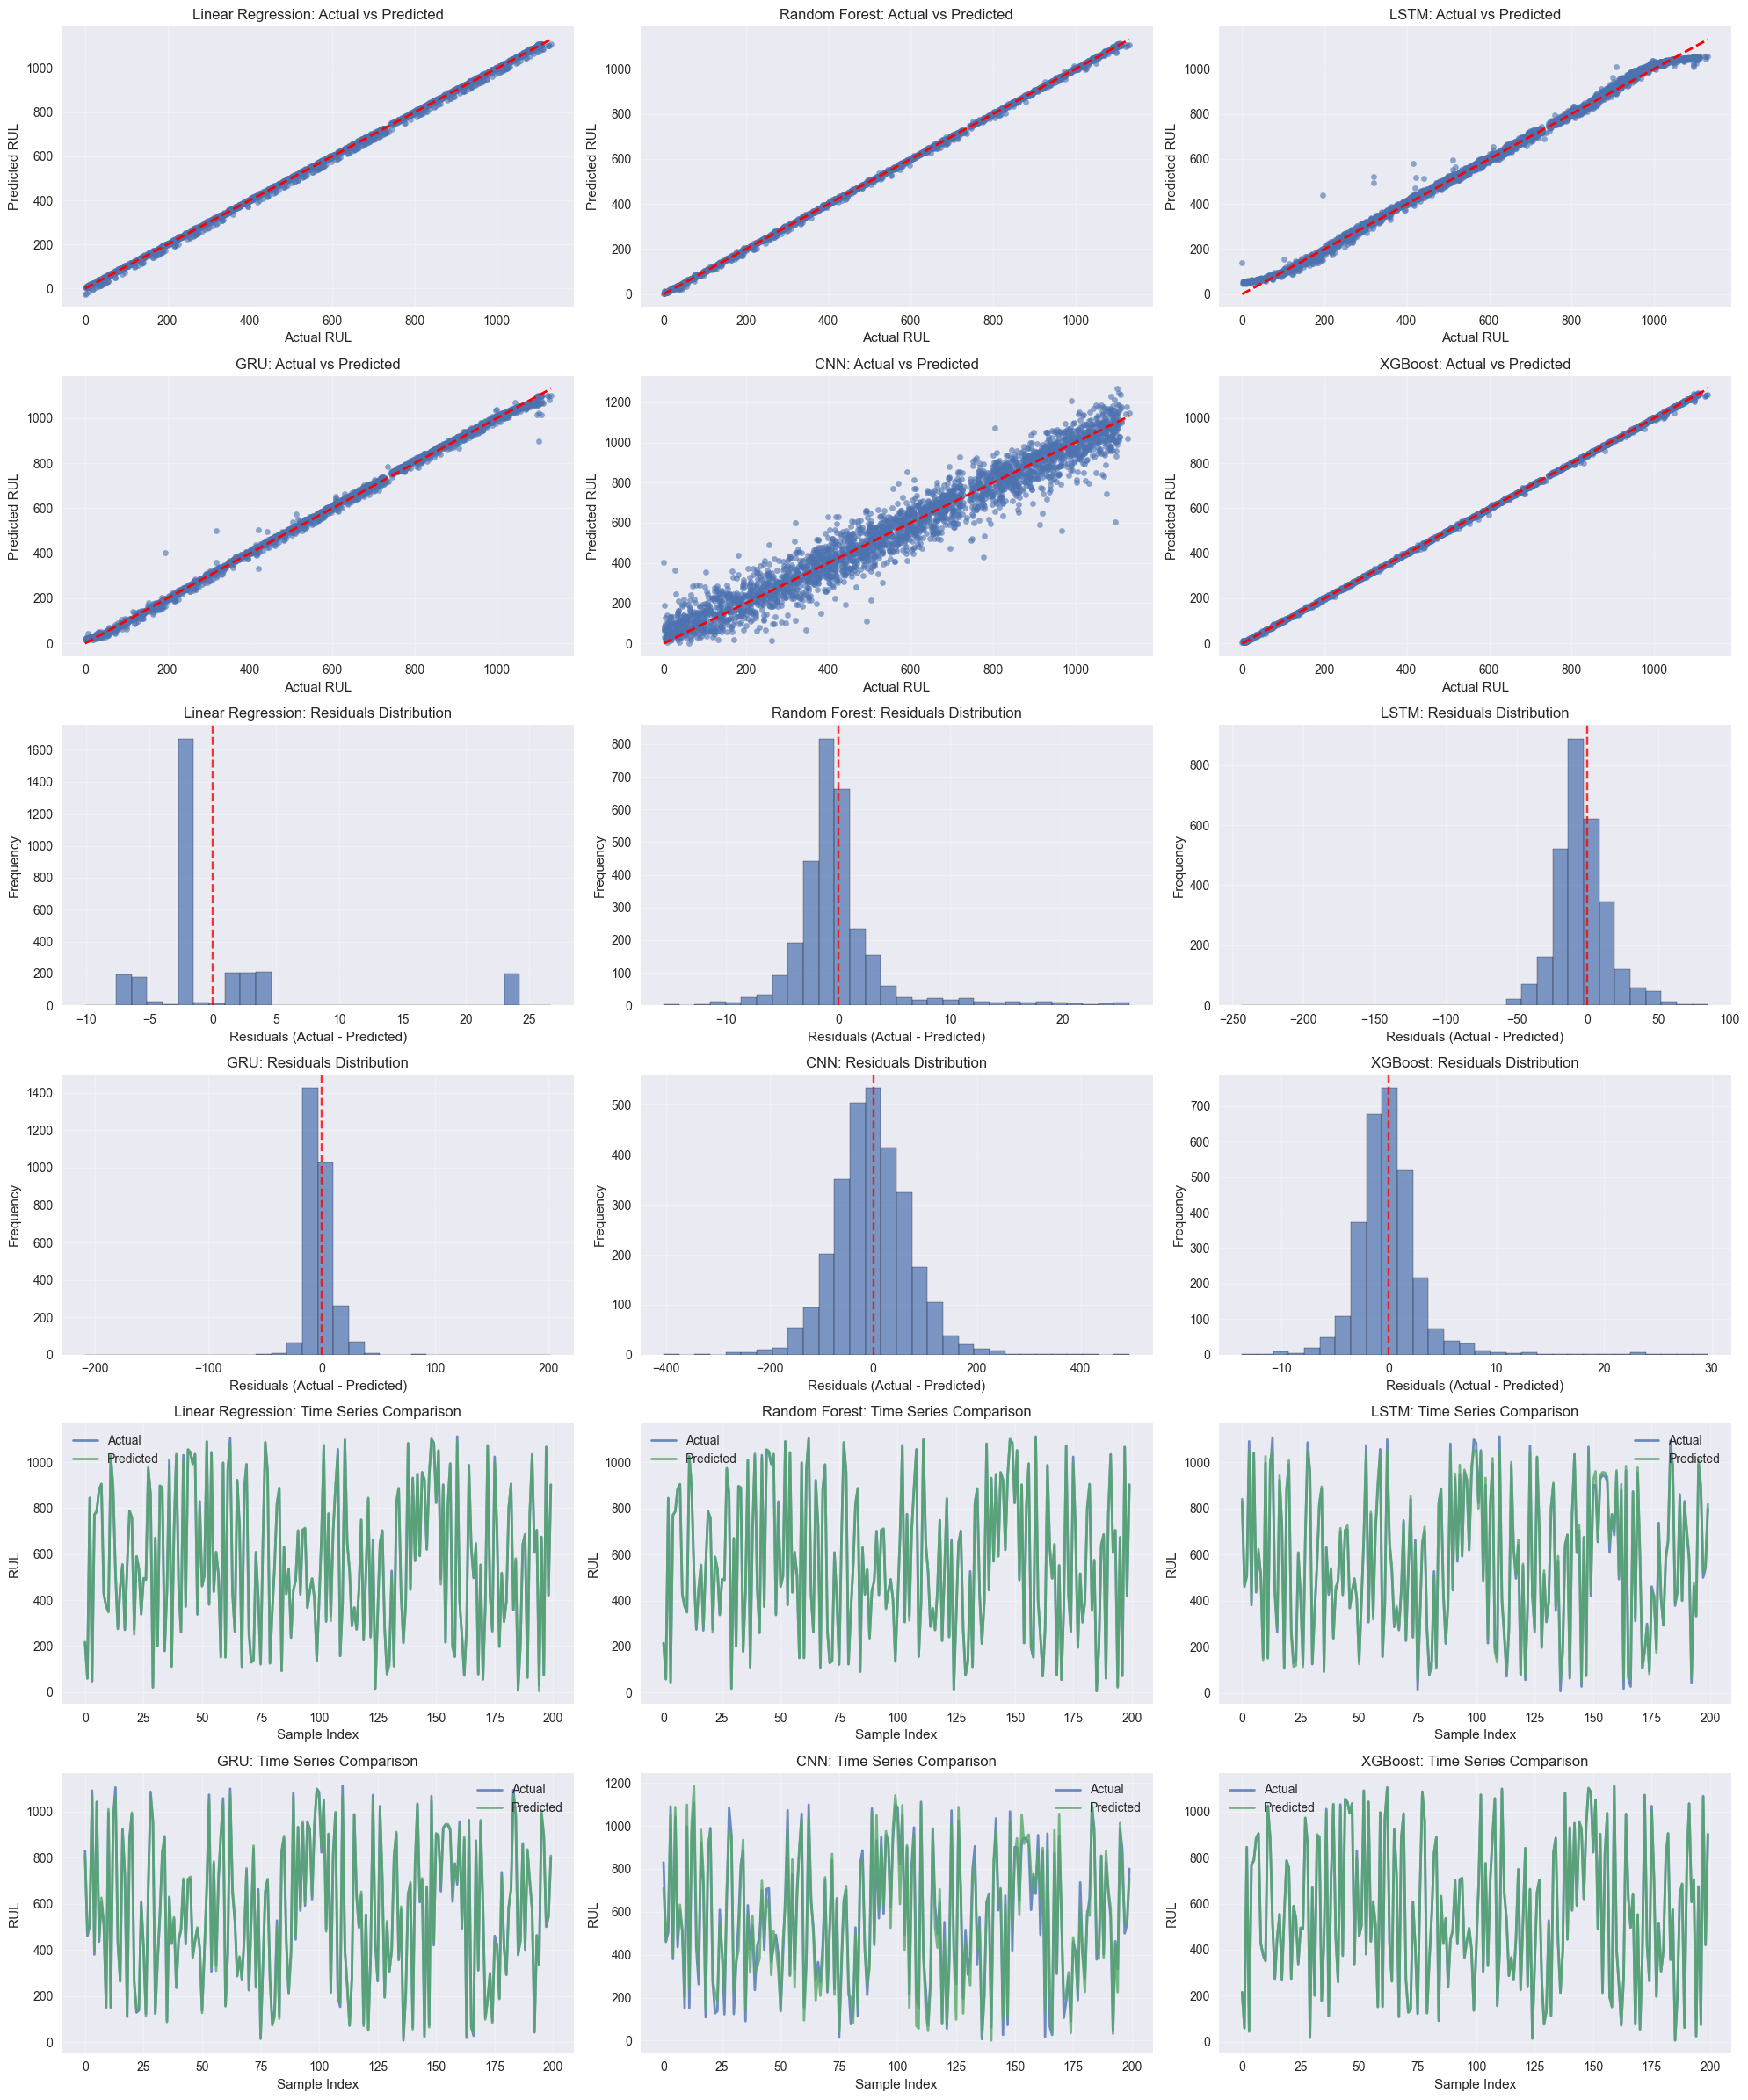

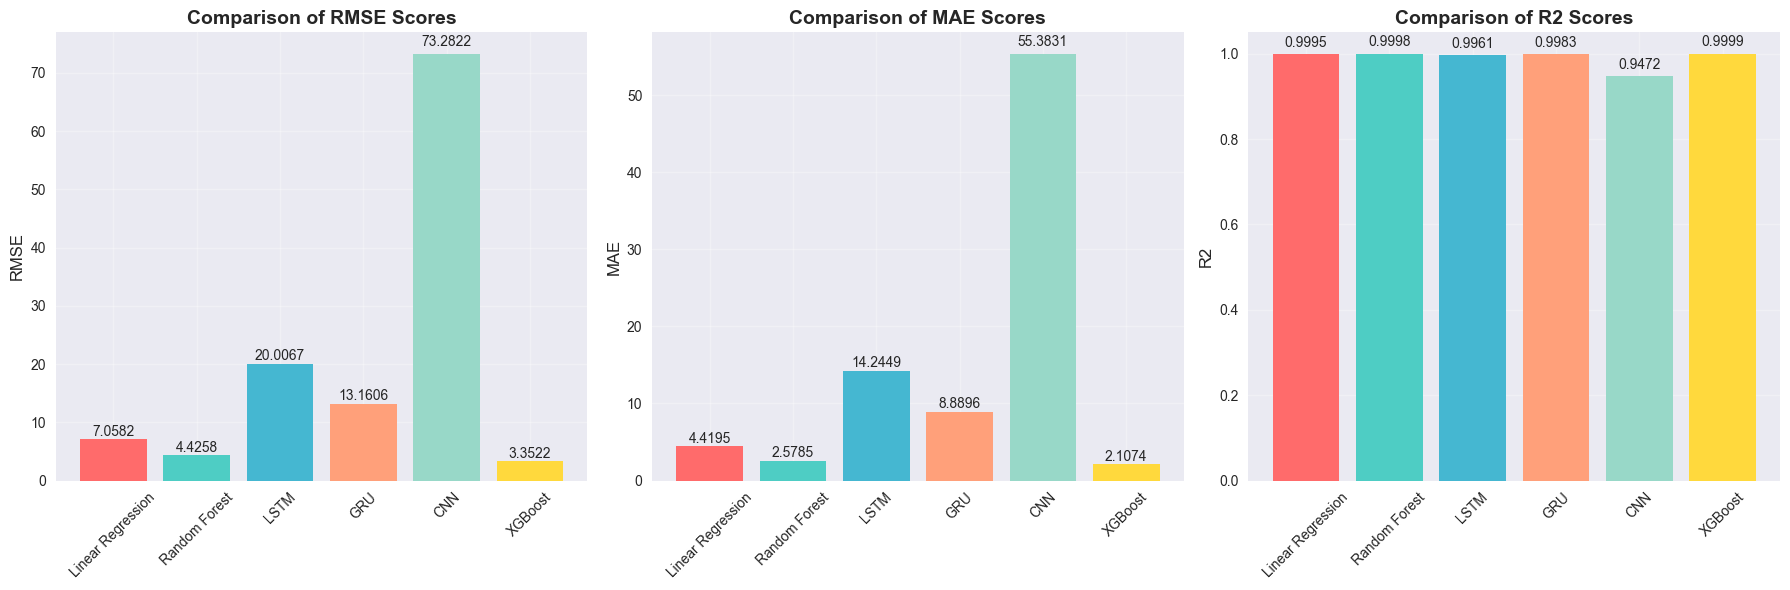

=== BẢNG SO SÁNH CHI TIẾT ===
                      RMSE      MAE      R2
Linear Regression   7.0582   4.4195  0.9995
Random Forest       4.4258   2.5785  0.9998
LSTM               20.0067  14.2449  0.9961
GRU                13.1606   8.8896  0.9983
CNN                73.2822  55.3831  0.9472
XGBoost             3.3522   2.1074  0.9999

=== KẾT QUẢ ===
Mô hình tốt nhất (RMSE thấp nhất): XGBoost (RMSE: 3.3522)
Mô hình tốt nhất (R2 cao nhất): XGBoost (R2: 0.9999)

=== PHÂN TÍCH CHI TIẾT ===
Linear Regression:
  - RMSE: 7.0582 (Tốt)
  - MAE:  4.4195 (Tốt)
  - R2:   0.9995 (Xuất sắc)

Random Forest:
  - RMSE: 4.4258 (Tốt)
  - MAE:  2.5785 (Tốt)
  - R2:   0.9998 (Xuất sắc)

LSTM:
  - RMSE: 20.0067 (Tốt)
  - MAE:  14.2449 (Tốt)
  - R2:   0.9961 (Xuất sắc)

GRU:
  - RMSE: 13.1606 (Tốt)
  - MAE:  8.8896 (Tốt)
  - R2:   0.9983 (Xuất sắc)

CNN:
  - RMSE: 73.2822 (Trung bình)
  - MAE:  55.3831 (Trung bình)
  - R2:   0.9472 (Xuất sắc)

XGBoost:
  - RMSE: 3.3522 (Tốt)
  - MAE:  2.1074 (Tốt)
  - R2:

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập style
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 24))

# Tạo dự đoán cho tất cả các mô hình
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()
y_pred_gru = gru_model.predict(X_test_seq).flatten()
y_pred_cnn = cnn_model.predict(X_test_seq).flatten()
y_pred_xgb = best_model.predict(X_test)

# Dictionary chứa tất cả dự đoán
predictions = {
    'Linear Regression': (y_test, y_pred_lr),
    'Random Forest': (y_test, y_pred_rf),
    'LSTM': (y_test_seq, y_pred_lstm),
    'GRU': (y_test_seq, y_pred_gru),
    'CNN': (y_test_seq, y_pred_cnn),
    'XGBoost': (y_test, y_pred_xgb)
}

# 1. Biểu đồ so sánh Actual vs Predicted cho tất cả mô hình
for i, (model_name, (y_true, y_pred)) in enumerate(predictions.items(), 1):
    plt.subplot(6, 3, i)
    plt.scatter(y_true, y_pred, alpha=0.6, s=20)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual RUL')
    plt.ylabel('Predicted RUL')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.grid(True, alpha=0.3)

# 2. Biểu đồ phân bố lỗi (Residuals) cho tất cả mô hình
for i, (model_name, (y_true, y_pred)) in enumerate(predictions.items(), 1):
    plt.subplot(6, 3, i + 6)
    residuals = y_true - y_pred
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Residuals Distribution')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    plt.grid(True, alpha=0.3)

# 3. Biểu đồ time series cho một số mẫu đầu tiên
for i, (model_name, (y_true, y_pred)) in enumerate(predictions.items(), 1):
    plt.subplot(6, 3, i + 12)
    sample_size = min(200, len(y_true))
    indices = range(sample_size)
    plt.plot(indices, y_true[:sample_size], label='Actual', linewidth=2, alpha=0.8)
    plt.plot(indices, y_pred[:sample_size], label='Predicted', linewidth=2, alpha=0.8)
    plt.xlabel('Sample Index')
    plt.ylabel('RUL')
    plt.title(f'{model_name}: Time Series Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Biểu đồ so sánh hiệu suất các mô hình
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['RMSE', 'MAE', 'R2']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#FFD93D']

for idx, metric in enumerate(metrics):
    model_names = list(results_df.index)
    values = results_df[metric].values
    
    bars = axes[idx].bar(model_names, values, color=colors)
    axes[idx].set_title(f'Comparison of {metric} Scores', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)
    
    # Thêm giá trị lên đỉnh cột
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("=== BẢNG SO SÁNH CHI TIẾT ===")
print(results_df.round(4))

# Tìm mô hình tốt nhất
best_model_rmse = results_df['RMSE'].idxmin()
best_model_r2 = results_df['R2'].idxmax()

print(f"\n=== KẾT QUẢ ===")
print(f"Mô hình tốt nhất (RMSE thấp nhất): {best_model_rmse} (RMSE: {results_df.loc[best_model_rmse, 'RMSE']:.4f})")
print(f"Mô hình tốt nhất (R2 cao nhất): {best_model_r2} (R2: {results_df.loc[best_model_r2, 'R2']:.4f})")

# Phân tích chi tiết
print(f"\n=== PHÂN TÍCH CHI TIẾT ===")
for model_name in results_df.index:
    rmse, mae, r2 = results_df.loc[model_name]
    print(f"{model_name}:")
    print(f"  - RMSE: {rmse:.4f} ({'Tốt' if rmse < 50 else 'Trung bình' if rmse < 100 else 'Cần cải thiện'})")
    print(f"  - MAE:  {mae:.4f} ({'Tốt' if mae < 40 else 'Trung bình' if mae < 80 else 'Cần cải thiện'})")
    print(f"  - R2:   {r2:.4f} ({'Xuất sắc' if r2 > 0.9 else 'Tốt' if r2 > 0.8 else 'Trung bình' if r2 > 0.7 else 'Cần cải thiện'})")
    print()

## 9. Dự đoán thử và đánh giá chi tiết

Đánh giá hiệu năng và trực quan hóa kết quả của mô hình.

DỰ ĐOÁN THỬ VỚI CÁC MÔ HÌNH TỐT NHẤT
Dự đoán cho 3000 mẫu ngẫu nhiên:
------------------------------------------------------------
             Actual_RUL      XGBoost  Random_Forest  Linear_Regression  \
Sample_1            463   462.850006         467.56             468.48   
Sample_2            919   917.530029         919.48             921.45   
Sample_3             33    33.020000          37.25              40.13   
Sample_4            283   283.339996         282.39             285.06   
Sample_5            296   300.489990         300.79             301.51   
...                 ...          ...            ...                ...   
Sample_2996         711   709.090027         712.10             713.16   
Sample_2997        1023  1008.340027        1006.00             999.29   
Sample_2998        1054  1048.430054        1048.04            1051.75   
Sample_2999         483   480.959991         472.63             459.36   
Sample_3000        1000   999.469971        1000.90    

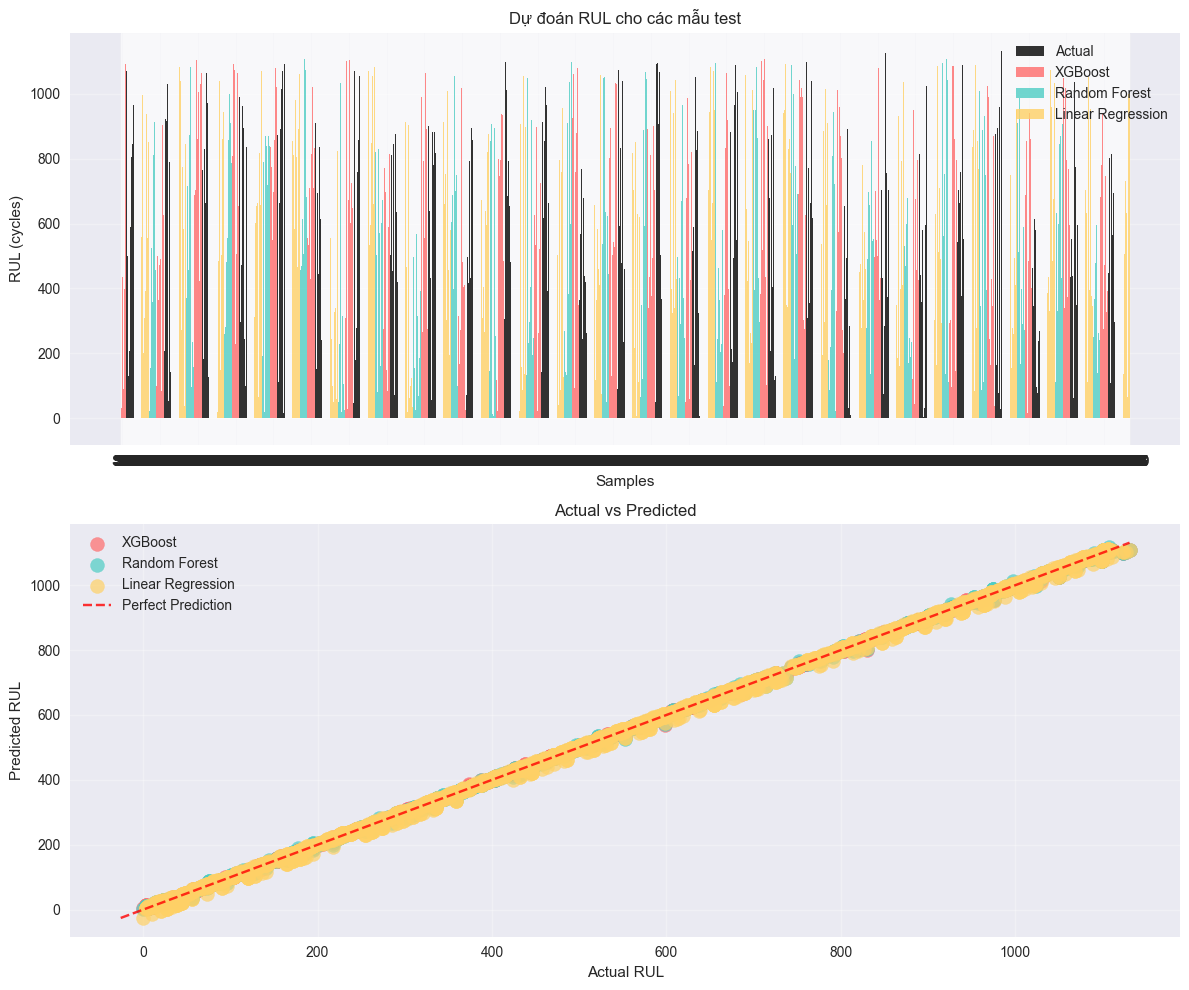


TÓM TẮT HIỆU SUẤT TRÊN CÁC MẪU TEST:

XGBoost:
 - Sai số trung bình: 2.08 cycles
 - Sai số lớn nhất: 29.65 cycles
 - Sai số nhỏ nhất: 0.00 cycles
 - Độ lệch chuẩn: 2.56 cycles

Random Forest:
 - Sai số trung bình: 2.67 cycles
 - Sai số lớn nhất: 25.97 cycles
 - Sai số nhỏ nhất: 0.00 cycles
 - Độ lệch chuẩn: 3.62 cycles

Linear Regression:
 - Sai số trung bình: 4.40 cycles
 - Sai số lớn nhất: 25.72 cycles
 - Sai số nhỏ nhất: 0.09 cycles
 - Độ lệch chuẩn: 5.46 cycles

SỐ LẦN TỪNG MÔ HÌNH DỰ ĐOÁN TỐT NHẤT:
 - XGBoost: 1463/3000 lần (48.8%)
 - Random Forest: 1297/3000 lần (43.2%)
 - Linear Regression: 240/3000 lần (8.0%)

Kết luận: Mô hình XGBoost cho kết quả dự đoán tốt nhất trên các mẫu test này.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print("DỰ ĐOÁN THỬ VỚI CÁC MÔ HÌNH TỐT NHẤT")
print("="*60)

# Reset index sau splitting
y_test = y_test.reset_index(drop=True)

# Chọn ngẫu nhiên 3000 mẫu từ tập test để dự đoán
sample_indices = np.random.choice(len(X_test), size=3000)
X_sample = X_test[sample_indices]
y_sample = y_test[sample_indices]

print(f"Dự đoán cho {len(sample_indices)} mẫu ngẫu nhiên:")
print("-" * 60)

# Dự đoán với các mô hình
predictions_sample = {}

# XGBoost (mô hình tốt nhất)
y_pred_xgb_sample = best_model.predict(X_sample)
predictions_sample['XGBoost'] = y_pred_xgb_sample

# Random Forest
y_pred_rf_sample = rf.predict(X_sample)
predictions_sample['Random Forest'] = y_pred_rf_sample

# Linear Regression
y_pred_lr_sample = lr.predict(X_sample)
predictions_sample['Linear Regression'] = y_pred_lr_sample

# Hiển thị kết quả dự đoán
results_table = pd.DataFrame({
    'Actual_RUL': y_sample.values,
    'XGBoost': y_pred_xgb_sample,
    'Random_Forest': y_pred_rf_sample,
    'Linear_Regression': y_pred_lr_sample
}, index=[f"Sample_{i+1}" for i in range(len(sample_indices))])

# Tính toán lỗi cho từng mẫu
results_table['XGB_Error'] = abs(results_table['Actual_RUL'] - results_table['XGBoost'])
results_table['RF_Error'] = abs(results_table['Actual_RUL'] - results_table['Random_Forest'])
results_table['LR_Error'] = abs(results_table['Actual_RUL'] - results_table['Linear_Regression'])

print(results_table.round(2))

print("\nPHÂN TÍCH CHI TIẾT:")
print("-" * 40)

for idx, row in results_table.iterrows():
    actual = row['Actual_RUL']
    xgb_pred = row['XGBoost']
    rf_pred = row['Random_Forest']
    lr_pred = row['Linear_Regression']
    
    print(f"\n{idx}:")
    print(f" - Thực tế: {actual:.2f} cycles")
    print(f" - XGBoost: {xgb_pred:.2f} cycles (sai số: {abs(actual-xgb_pred):.2f})")
    print(f" - Random Forest: {rf_pred:.2f} cycles (sai số: {abs(actual-rf_pred):.2f})")
    print(f" - Linear Regression: {lr_pred:.2f} cycles (sai số: {abs(actual-lr_pred):.2f})")
    
    # Xác định mô hình dự đoán tốt nhất cho mẫu này
    errors = {
        'XGBoost': abs(actual - xgb_pred),
        'Random Forest': abs(actual - rf_pred),
        'Linear Regression': abs(actual - lr_pred)
    }
    best_model_sample = min(errors, key=errors.get)
    print(f"Mô hình tốt nhất: {best_model_sample} (sai số: {errors[best_model_sample]:.2f})")

# Trực quan hóa kết quả dự đoán
fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # Chỉ dùng 2 biểu đồ, xếp dọc

# 1. Biểu đồ so sánh dự đoán
x_pos = np.arange(len(sample_indices))
width = 0.2

axes[0].bar(x_pos - width, results_table['Actual_RUL'], width, label='Actual', color='black', alpha=0.8)
axes[0].bar(x_pos, results_table['XGBoost'], width, label='XGBoost', color='#FF6B6B', alpha=0.8)
axes[0].bar(x_pos + width, results_table['Random_Forest'], width, label='Random Forest', color='#4ECDC4', alpha=0.8)
axes[0].bar(x_pos + 2*width, results_table['Linear_Regression'], width, label='Linear Regression', color='#FFD166', alpha=0.8)

axes[0].set_xlabel('Samples')
axes[0].set_ylabel('RUL (cycles)')
axes[0].set_title('Dự đoán RUL cho các mẫu test')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'S{i+1}' for i in range(len(sample_indices))])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Scatter plot: Actual vs Predicted
axes[1].scatter(results_table['Actual_RUL'], results_table['XGBoost'], 
                label='XGBoost', color='#FF6B6B', s=100, alpha=0.7)
axes[1].scatter(results_table['Actual_RUL'], results_table['Random_Forest'], 
                label='Random Forest', color='#4ECDC4', s=100, alpha=0.7)
axes[1].scatter(results_table['Actual_RUL'], results_table['Linear_Regression'], 
                label='Linear Regression', color='#FFD166', s=100, alpha=0.7)

# Đường hoàn hảo
min_val = min(results_table['Actual_RUL'].min(), 
              results_table[['XGBoost', 'Random_Forest', 'Linear_Regression']].min().min())
max_val = max(results_table['Actual_RUL'].max(), 
              results_table[['XGBoost', 'Random_Forest', 'Linear_Regression']].max().max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')

axes[1].set_xlabel('Actual RUL')
axes[1].set_ylabel('Predicted RUL')
axes[1].set_title('Actual vs Predicted')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tóm tắt hiệu suất trên các mẫu test
print("\nTÓM TẮT HIỆU SUẤT TRÊN CÁC MẪU TEST:")
print("=" * 50)

models_sample_performance = {
    'XGBoost': results_table['XGB_Error'],
    'Random Forest': results_table['RF_Error'],
    'Linear Regression': results_table['LR_Error']
}

for model_name, errors in models_sample_performance.items():
    mean_error = errors.mean()
    max_error = errors.max()
    min_error = errors.min()
    std_error = errors.std()
    
    print(f"\n{model_name}:")
    print(f" - Sai số trung bình: {mean_error:.2f} cycles")
    print(f" - Sai số lớn nhất: {max_error:.2f} cycles")
    print(f" - Sai số nhỏ nhất: {min_error:.2f} cycles")
    print(f" - Độ lệch chuẩn: {std_error:.2f} cycles")

# Đếm số lần mỗi mô hình dự đoán tốt nhất
best_predictions = []
for _, row in results_table.iterrows():
    errors = {
        'XGBoost': row['XGB_Error'],
        'Random Forest': row['RF_Error'],
        'Linear Regression': row['LR_Error']
    }
    best_model_sample = min(errors, key=errors.get)
    best_predictions.append(best_model_sample)

best_count = Counter(best_predictions)

print(f"\nSỐ LẦN TỪNG MÔ HÌNH DỰ ĐOÁN TỐT NHẤT:")
for model, count in best_count.items():
    percentage = (count / len(best_predictions)) * 100
    print(f" - {model}: {count}/{len(best_predictions)} lần ({percentage:.1f}%)")

print(f"\nKết luận: Mô hình {'XGBoost' if best_count.get('XGBoost', 0) == max(best_count.values()) else max(best_count, key=best_count.get)} cho kết quả dự đoán tốt nhất trên các mẫu test này.")

Top 20 feature importance:
Cycle_Index                  0.998449
Discharge_Rolling_Mean_10    0.001138
Max. Voltage Dischar. (V)    0.000054
Efficiency_Ratio             0.000044
Voltage_Drop_Rate            0.000043
Charging time (s)            0.000041
Discharge Time (s)           0.000040
Min. Voltage Charg. (V)      0.000037
Time at 4.15V (s)            0.000037
Decrement 3.6-3.4V (s)       0.000035
Discharge_Rolling_Std_10     0.000025
Prev_Cycle_Discharge         0.000022
Time constant current (s)    0.000020
Discharge_Drop_Rate          0.000016
dtype: float64


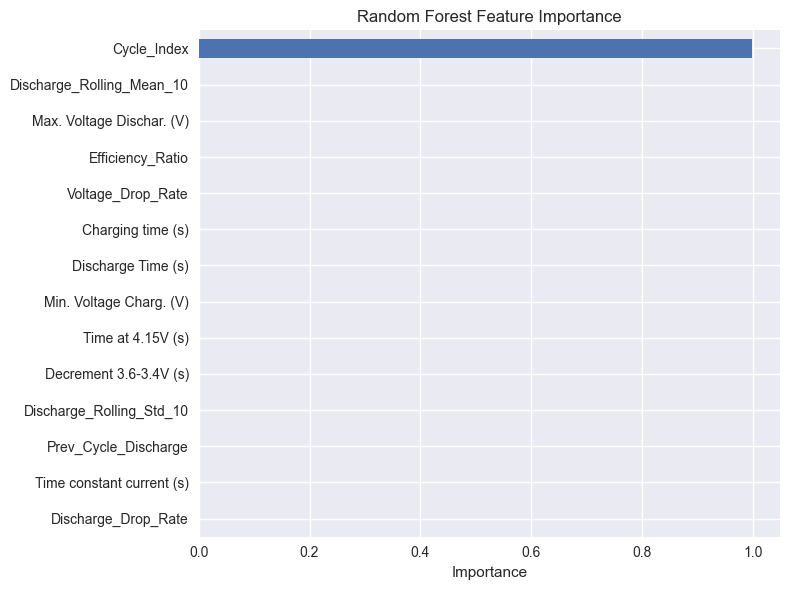

Phân bố residuals (Actual - Predicted) của Random Forest:


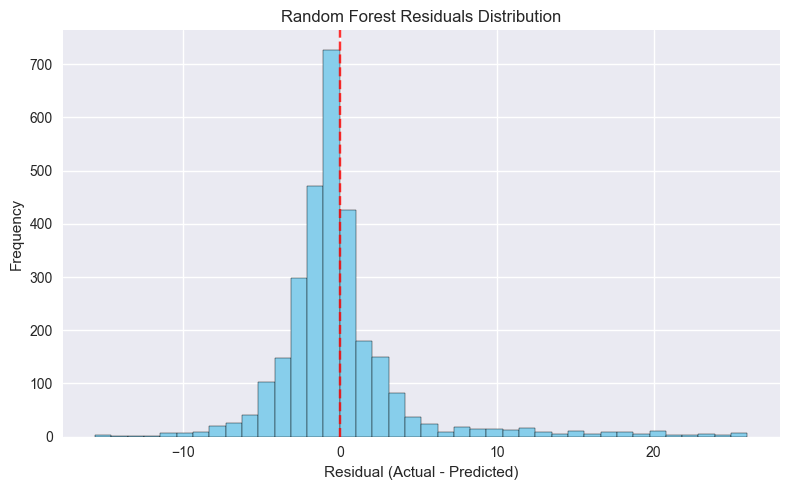

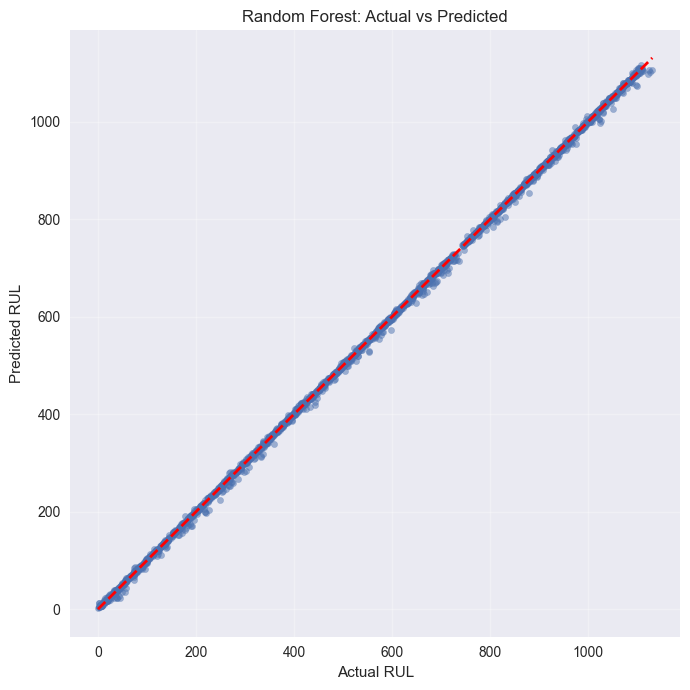

In [21]:
# === PHÂN TÍCH RANDOM FOREST: Feature Importance & Residuals ===
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance
try:
    feature_names = df.drop(columns=['RUL']).columns
except Exception:
    feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

fi = pd.Series(rf.feature_importances_, index=feature_names)
print('Top 20 feature importance:')
print(fi.sort_values(ascending=False).head(20))
fi.sort_values().plot(kind='barh', figsize=(8,6), title='Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Residuals
print('Phân bố residuals (Actual - Predicted) của Random Forest:')
y_pred_rf = rf.predict(X_test)
residuals = y_test - y_pred_rf
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=40, color='skyblue', edgecolor='black')
plt.title('Random Forest Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

# Scatter plot Actual vs Predicted
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_rf, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()